In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:
import os
import zipfile
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
import zipfile
import os

# Path to your newly downloaded file
file_path = "/content/drive/MyDrive/AI_Models/diabetic_eyes/hospital_clinicas_dataset.zip"

# Check file properties
if os.path.exists(file_path):
    file_size = os.path.getsize(file_path)
    print(f"✅ File found! Size: {file_size / (1024*1024):.2f} MB")

    # Test zip file integrity
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            test_result = zip_ref.testzip()
            if test_result is None:
                print("🎉 SUCCESS! Zip file is valid and intact!")

                file_list = zip_ref.namelist()
                print(f"📁 Contains {len(file_list)} files")

                # Show first few files to preview structure
                print("\nFirst 10 files in dataset:")
                for i, filename in enumerate(file_list[:10]):
                    print(f"  {i+1}. {filename}")

                print(f"\n... and {len(file_list)-10} more files")

            else:
                print(f"❌ Corrupted file: {test_result}")

    except zipfile.BadZipFile:
        print("❌ Invalid zip file format")
    except Exception as e:
        print(f"❌ Error: {e}")
else:
    print("❌ File not found. Check the path.")


✅ File found! Size: 357.70 MB
🎉 SUCCESS! Zip file is valid and intact!
📁 Contains 765 files

First 10 files in dataset:
  1. 1. No DR signs/
  2. 1. No DR signs/1.jpg
  3. 1. No DR signs/10.jpg
  4. 1. No DR signs/100.jpg
  5. 1. No DR signs/101.jpg
  6. 1. No DR signs/102.jpg
  7. 1. No DR signs/103.jpg
  8. 1. No DR signs/104.jpg
  9. 1. No DR signs/105.jpg
  10. 1. No DR signs/106.jpg

... and 755 more files


In [5]:
# Extract the dataset to organized folders
extract_path = "/content/drive/MyDrive/AI_Models/diabetic_eyes/hospital_dataset/"

# Create extraction directory
os.makedirs(extract_path, exist_ok=True)

# Extract all files
print("🔄 Extracting dataset...")
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Dataset extracted successfully to: {extract_path}")

# Show the folder structure
print("\n📂 Dataset Structure:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    folder_name = os.path.basename(root)
    print(f"{indent}{folder_name}/ ({len(files)} files)")

    # Show first few image files in each folder
    subindent = ' ' * 2 * (level + 1)
    image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img in image_files[:3]:
        print(f"{subindent}{img}")
    if len(image_files) > 3:
        print(f"{subindent}... and {len(image_files)-3} more images")


🔄 Extracting dataset...
✅ Dataset extracted successfully to: /content/drive/MyDrive/AI_Models/diabetic_eyes/hospital_dataset/

📂 Dataset Structure:
/ (1 files)
1. No DR signs/ (187 files)
  1.jpg
  100.jpg
  10.jpg
  ... and 184 more images
2. Mild (or early) NPDR/ (4 files)
  188.jpg
  190.jpg
  189.jpg
  ... and 1 more images
3. Moderate NPDR/ (80 files)
  192.jpg
  193.jpg
  194.jpg
  ... and 77 more images
4. Severe NPDR/ (176 files)
  272.jpg
  273.jpg
  276.jpg
  ... and 173 more images
5. Very Severe NPDR/ (108 files)
  448.jpg
  449.jpg
  450.jpg
  ... and 105 more images
6. PDR/ (88 files)
  556.jpg
  557.jpg
  558.jpg
  ... and 85 more images
7. Advanced PDR/ (114 files)
  645.jpg
  646.jpg
  648.jpg
  ... and 111 more images


In [6]:
import pandas as pd

def create_hospital_dataframe(base_path):
    """Create DataFrame from Hospital de Clínicas dataset"""

    # 7-class to 5-class mapping for your existing model
    class_mapping = {
        'No_DR_signs': 0,
        'Mild_NPDR': 1,
        'Moderate_NPDR': 2,
        'Severe_NPDR': 3,
        'Very_Severe_NPDR': 3,  # Map to Severe (class 3)
        'PDR': 4,               # Map to Proliferative (class 4)
        'Advanced_PDR': 4       # Map to Proliferative (class 4)
    }

    data = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                folder_name = os.path.basename(root)

                # Map folder name to class
                class_label = None
                for class_name, class_num in class_mapping.items():
                    if class_name.lower().replace('_', '').replace(' ', '') in folder_name.lower().replace('_', '').replace(' ', ''):
                        class_label = class_num
                        break

                if class_label is not None:
                    full_path = os.path.join(root, file)
                    data.append({
                        'image_path': full_path,
                        'label': class_label,
                        'original_class': folder_name,
                        'filename': file
                    })

    df = pd.DataFrame(data)
    return df

# Create the DataFrame
hospital_df = create_hospital_dataframe(extract_path)
print(f"\n📊 Dataset Summary:")
print(f"Total images: {len(hospital_df)}")
print("\nClass distribution (5-class system):")
print(hospital_df['label'].value_counts().sort_index())



📊 Dataset Summary:
Total images: 757

Class distribution (5-class system):
label
0    187
2     80
3    284
4    206
Name: count, dtype: int64


In [15]:
def preprocess_hospital_dataset_no_filtering(hospital_df, save_processed=True):
    """
    Preprocess ALL images without quality filtering
    Medical datasets are pre-screened by professionals
    """
    processed_data = []
    stats = {"processed": 0, "failed": 0}

    # Create directory for processed images
    if save_processed:
        processed_dir = "/content/drive/MyDrive/AI_Models/diabetic_eyes/processed_hospital_dataset/"
        os.makedirs(processed_dir, exist_ok=True)

    print("🔄 Preprocessing ALL Hospital de Clínicas images (no quality filtering)...")
    print("💡 Trusting medical professionals' image selection")

    for idx, row in tqdm(hospital_df.iterrows(), total=len(hospital_df)):
        image_path = row['image_path']

        # Process image without quality check
        processed_img, success = preprocess_fundus_image(image_path)

        if not success or processed_img is None:
            stats["failed"] += 1
            continue

        stats["processed"] += 1

        # Save processed image
        if save_processed:
            processed_filename = f"processed_{os.path.basename(image_path)}"
            processed_path = os.path.join(processed_dir, processed_filename)

            # Convert back to PIL Image and save
            pil_img = Image.fromarray((processed_img * 255).astype(np.uint8))
            pil_img.save(processed_path)

            processed_data.append({
                'original_path': image_path,
                'processed_path': processed_path,
                'label': row['label'],
                'original_class': row['original_class'],
                'filename': processed_filename
            })
        else:
            processed_data.append({
                'original_path': image_path,
                'processed_image': processed_img,
                'label': row['label'],
                'original_class': row['original_class'],
                'filename': os.path.basename(image_path)
            })

    # Create processed DataFrame
    processed_df = pd.DataFrame(processed_data)

    print(f"\n📊 Processing Results:")
    print(f"✅ Successfully processed: {stats['processed']}")
    print(f"❌ Failed to process: {stats['failed']}")
    print(f"📈 Success rate: {stats['processed']/len(hospital_df)*100:.1f}%")

    return processed_df, stats

print("✅ No-filtering preprocessing function ready")


✅ No-filtering preprocessing function ready


In [16]:
# Import missing dependencies
from tqdm import tqdm
import os
import numpy as np
from PIL import Image

print("✅ All required imports added")



✅ All required imports added


In [17]:

def preprocess_fundus_image_fast(image_path, target_size=(224, 224)):
    """
    Fast preprocessing - just resize and normalize
    """
    try:
        # Read and convert image
        image = cv2.imread(image_path)
        if image is None:
            return None, False

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Just resize and normalize - skip expensive operations
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        image = image.astype(np.float32) / 255.0

        return image, True

    except Exception as e:
        return None, False

def preprocess_hospital_dataset_fast(hospital_df):
    """
    Fast preprocessing without saving files
    """
    processed_data = []
    stats = {"processed": 0, "failed": 0}

    print("🚀 Fast preprocessing (in-memory only)...")

    for idx, row in tqdm(hospital_df.iterrows(), total=len(hospital_df)):
        image_path = row['image_path']

        processed_img, success = preprocess_fundus_image_fast(image_path)

        if success and processed_img is not None:
            stats["processed"] += 1
            processed_data.append({
                'original_path': image_path,
                'processed_image': processed_img,
                'label': row['label'],
                'original_class': row['original_class'],
                'filename': os.path.basename(image_path)
            })
        else:
            stats["failed"] += 1

    processed_df = pd.DataFrame(processed_data)
    print(f"✅ Fast preprocessing complete: {stats['processed']}/{len(hospital_df)} images")

    return processed_df, stats

# Run fast preprocessing
processed_hospital_df_fast, stats_fast = preprocess_hospital_dataset_fast(hospital_df)




🚀 Fast preprocessing (in-memory only)...


100%|██████████| 757/757 [00:59<00:00, 12.67it/s]

✅ Fast preprocessing complete: 757/757 images


In [18]:
# Show class distribution of processed images
print(f"📊 Processed Hospital de Clínicas Dataset Summary:")
print(f"Total processed images: {len(processed_hospital_df_fast)}")
print("\nClass distribution:")
print(processed_hospital_df_fast['label'].value_counts().sort_index())

# Show sample of the processed data
print("\nSample of processed data:")
print(processed_hospital_df_fast.head())


📊 Processed Hospital de Clínicas Dataset Summary:
Total processed images: 757

Class distribution:
label
0    187
2     80
3    284
4    206
Name: count, dtype: int64

Sample of processed data:
                                       original_path  \
0  /content/drive/MyDrive/AI_Models/diabetic_eyes...   
1  /content/drive/MyDrive/AI_Models/diabetic_eyes...   
2  /content/drive/MyDrive/AI_Models/diabetic_eyes...   
3  /content/drive/MyDrive/AI_Models/diabetic_eyes...   
4  /content/drive/MyDrive/AI_Models/diabetic_eyes...   

                                     processed_image  label  original_class  \
0  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0  1. No DR signs   
1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0  1. No DR signs   
2  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0  1. No DR signs   
3  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0  1. No DR signs   
4  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0  1. No DR sign

In [19]:
def create_preprocessed_test_generator(processed_df, batch_size=32):
    """
    Create generator for in-memory preprocessed images
    """
    from tensorflow.keras.utils import to_categorical

    # Convert labels to strings for consistency
    processed_df_copy = processed_df.copy()
    processed_df_copy['label'] = processed_df_copy['label'].astype(str)

    # Create custom generator for in-memory images
    def generator():
        while True:
            for start in range(0, len(processed_df_copy), batch_size):
                end = min(start + batch_size, len(processed_df_copy))
                batch_df = processed_df_copy.iloc[start:end]

                images = []
                labels = []

                for _, row in batch_df.iterrows():
                    images.append(row['processed_image'])
                    labels.append(int(row['label']))

                images = np.array(images)
                labels = to_categorical(labels, num_classes=5)  # 5 DR classes

                yield images, labels

    return generator(), len(processed_df_copy)

# Create test generator
hospital_test_gen, num_samples = create_preprocessed_test_generator(processed_hospital_df_fast)


In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("🧪 Testing your trained DR model on Hospital de Clínicas dataset...")

# Calculate steps for evaluation
steps = len(processed_hospital_df_fast) // 32 + (1 if len(processed_hospital_df_fast) % 32 > 0 else 0)

# Evaluate model
test_loss, test_accuracy = model.evaluate(hospital_test_gen, steps=steps)
print(f"📈 Test Results on Clinical Dataset:")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss:.4f}")

# Get detailed predictions
print("\n🔍 Getting detailed predictions...")
predictions = model.predict(hospital_test_gen, steps=steps)
y_pred = np.argmax(predictions, axis=1)
y_true = processed_hospital_df_fast['label'].astype(int).values

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'],
            yticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Hospital de Clínicas Dataset')
plt.show()

# Classification Report
print("\n📊 Detailed Classification Report:")
print(classification_report(y_true, y_pred,
                          target_names=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']))


🧪 Testing your trained DR model on Hospital de Clínicas dataset...


NameError: name 'model' is not defined

In [21]:
import os

# Check for saved models in your AI_Models directory
model_dir = "/content/drive/MyDrive/AI_Models/"
if os.path.exists(model_dir):
    print("🔍 Looking for saved models...")
    for file in os.listdir(model_dir):
        if file.endswith(('.keras', '.h5')):
            print(f"Found model: {file}")
else:
    print("❌ AI_Models directory not found")

# Also check current directory
print("\n🔍 Checking current directory...")
for file in os.listdir('.'):
    if file.endswith(('.keras', '.h5')):
        print(f"Found model: {file}")


🔍 Looking for saved models...

🔍 Checking current directory...


In [33]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Rebuild model architecture for 4 classes (Hospital dataset)
base_model = MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # Changed from 5 to 4 classes

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("✅ Model rebuilt for 4 classes (Hospital de Clínicas dataset)")
model.summary()


✅ Model rebuilt for 4 classes (Hospital de Clínicas dataset)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
# Use the class weights that fixed your imbalance issue
class_weight_dict = {
    0: 0.2751,   # No DR (majority class - lower weight)
    1: 2.8095,   # Mild DR
    2: 1.3053,   # Moderate DR
    3: 8.1021,   # Severe DR (high weight for minority class)
    4: 8.3634    # Proliferative DR (highest weight for rarest class)
}

print("✅ Class weights configured for balanced training")
print("Class weights:", class_weight_dict)


✅ Class weights configured for balanced training
Class weights: {0: 0.2751, 1: 2.8095, 2: 1.3053, 3: 8.1021, 4: 8.3634}


In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train/validation split (using your recreated df)
train_df, val_df = train_test_split(
    hospital_df,
    test_size=0.2,
    stratify=hospital_df['label'],
    random_state=42
)

# Convert labels to strings for Keras
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

print(f"✅ Dataset split completed:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create data generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
).flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("✅ Data generators created successfully!")

✅ Dataset split completed:
Training samples: 605
Validation samples: 152
Found 605 validated image filenames belonging to 4 classes.
Found 152 validated image filenames belonging to 4 classes.
✅ Data generators created successfully!


In [36]:
# Updated class weights for Hospital de Clínicas dataset (4 classes)
class_weight_dict_hospital = {
    0: 0.27,    # No DR (187 images) - lower weight
    2: 1.31,    # Moderate DR (80 images) - medium weight
    3: 1.45,    # Severe DR (284 images) - medium weight
    4: 2.01     # Proliferative DR (206 images) - higher weight
}

print("Updated class weights for Hospital dataset:", class_weight_dict_hospital)


Updated class weights for Hospital dataset: {0: 0.27, 2: 1.31, 3: 1.45, 4: 2.01}


In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train with the 4-class weights
print("🚀 Starting training on Hospital de Clínicas dataset (4 classes)...")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight_dict_hospital,  # Updated for 4 classes
    callbacks=[early_stop],
    verbose=1
)

print("✅ Training completed!")


🚀 Starting training on Hospital de Clínicas dataset (4 classes)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.2677 - loss: 1.4866 - val_accuracy: 0.3553 - val_loss: 1.4486
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.3366 - loss: 1.3197 - val_accuracy: 0.3947 - val_loss: 1.4495
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.3570 - loss: 1.2713 - val_accuracy: 0.3882 - val_loss: 1.3949
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.4098 - loss: 1.1872 - val_accuracy: 0.4211 - val_loss: 1.3429
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.3563 - loss: 1.3385 - val_accuracy: 0.4605 - val_loss: 1.3166
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.3852 - loss: 1.1496 - val_accuracy: 0.4342 - val_loss: 1.2918
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.3531 - loss: 1.2610 - val_accuracy: 0.4605 - val_loss: 1.2645
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.4002 - loss: 1.1826 - val_accuracy: 0.4803 - val_loss:

In [38]:
# Evaluate the trained model on validation data
print("📊 Evaluating 4-Class Hospital DR Model")
print("=" * 50)

val_loss, val_accuracy = model.evaluate(val_gen, verbose=1)
print(f"\n🎯 Validation Results:")
print(f"Accuracy: {val_accuracy:.2%}")
print(f"Loss: {val_loss:.4f}")


📊 Evaluating 4-Class Hospital DR Model
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4730 - loss: 1.2282

🎯 Validation Results:
Accuracy: 48.03%
Loss: 1.2051


In [39]:
from datetime import datetime
import json
import os

# Create timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the main model
model_filename = f'hospital_dr_model_4class_{timestamp}.keras'
model.save(model_filename)
print(f"✅ Model saved as: {model_filename}")

# Also save to Google Drive if available
try:
    # Create directory if it doesn't exist
    drive_dir = '/content/drive/MyDrive/AI_Models/diabetic_eyes/'
    os.makedirs(drive_dir, exist_ok=True)

    drive_model_path = os.path.join(drive_dir, model_filename)
    model.save(drive_model_path)
    print(f"✅ Model also saved to Google Drive: {drive_model_path}")
except Exception as e:
    print(f"⚠️ Could not save to Google Drive: {e}")


✅ Model saved as: hospital_dr_model_4class_20250728_085318.keras
✅ Model also saved to Google Drive: /content/drive/MyDrive/AI_Models/diabetic_eyes/hospital_dr_model_4class_20250728_085318.keras


In [41]:
# COMPLETE ONE-CELL ACCURACY IMPROVEMENT SOLUTION
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Recreate train/val split
train_df, val_df = train_test_split(hospital_df, test_size=0.2, stratify=hospital_df['label'], random_state=42)
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# ENHANCED DATA AUGMENTATION (increases effective dataset size)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,           # Increased from 20
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,             # Increased from 0.1
    width_shift_range=0.1,      # New - helps with positioning
    height_shift_range=0.1,     # New - helps with positioning
    brightness_range=[0.8, 1.2], # New - handles lighting variations
    shear_range=0.1,            # New - geometric variations
    fill_mode='nearest'
).flow_from_dataframe(train_df, x_col='image_path', y_col='label', target_size=(224, 224),
                     class_mode='categorical', batch_size=16, shuffle=True)  # Smaller batch size

val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df, x_col='image_path', y_col='label', target_size=(224, 224),
    class_mode='categorical', batch_size=16, shuffle=False)

# IMPROVED MODEL ARCHITECTURE with more regularization
base_model = MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)  # Increased dropout from 0.3 to 0.5
x = Dense(128, activation='relu')(x)  # Added intermediate layer
x = Dropout(0.3)(x)  # Additional dropout
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False

# FINE-TUNING: Unfreeze top layers of MobileNetV2 for better adaptation
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# OPTIMIZED TRAINING SETUP
optimizer = Adam(learning_rate=1e-5)  # Much lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ENHANCED CLASS WEIGHTS (more aggressive for minority classes)
class_weight_dict_improved = {
    0: 0.5,    # Reduced weight for majority class
    1: 2.5,    # Increased for Moderate DR
    2: 0.8,    # Balanced for Severe DR
    3: 1.2     # Increased for Proliferative DR
}

# ADVANCED CALLBACKS
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
]

# EXTENDED TRAINING with fine-tuning
print("🚀 Training improved model with enhanced augmentation and fine-tuning...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,  # Increased epochs
    class_weight=class_weight_dict_improved,
    callbacks=callbacks,
    verbose=1
)

# EVALUATE RESULTS
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"\n🎯 IMPROVED RESULTS:")
print(f"Previous Accuracy: 48.03%")
print(f"New Accuracy: {val_accuracy:.2%}")
print(f"Improvement: {val_accuracy - 0.4803:.1%}")

Found 605 validated image filenames belonging to 4 classes.
Found 152 validated image filenames belonging to 4 classes.
🚀 Training improved model with enhanced augmentation and fine-tuning...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1587 - loss: 2.1870 - val_accuracy: 0.1053 - val_loss: 2.7348 - learning_rate: 1.0000e-05
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.1858 - loss: 1.8705 - val_accuracy: 0.1184 - val_loss: 2.5029 - learning_rate: 1.0000e-05
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.2513 - loss: 1.5596 - val_accuracy: 0.1316 - val_loss: 2.3115 - learning_rate: 1.0000e-05
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.3192 - loss: 1.4896 - val_accuracy: 0.1447 - val_loss: 2.1795 - learning_rate: 1.0000e-05
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.3318 - loss: 1.3812 - val_accuracy: 0.1513 - val_loss: 2.0597 - learning_rate: 1.0000e-05
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.3732 - loss: 1.4535 - val_accuracy: 0.1974 - val_loss: 1.9343 - learning_rate: 1.0000e-05
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.3680 - loss:

📊 EVALUATING IMPROVED 4-CLASS HOSPITAL DR MODEL
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 771ms/step - accuracy: 0.6851 - loss: 0.8735

🎯 PERFORMANCE COMPARISON:
Previous Model Accuracy: 48.03%
Improved Model Accuracy: 66.45%
Accuracy Improvement: +18.4%
Validation Loss: 0.8952

🔍 GENERATING DETAILED PREDICTIONS...
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 917ms/step

📈 DETAILED RESULTS:
Total validation samples: 152
Correct predictions: 101
Incorrect predictions: 51
Accuracy: 66.45%

📊 DETAILED CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

           No DR       0.79      0.79      0.79        38
     Moderate DR       0.27      0.50      0.35        16
       Severe DR       0.77      0.58      0.66        57
Proliferative DR       0.73      0.73      0.73        41

        accuracy                           0.66       152
       macro avg       0.64      0.65      0.63       152
    weighted avg       0.71      0.66      0.68       152



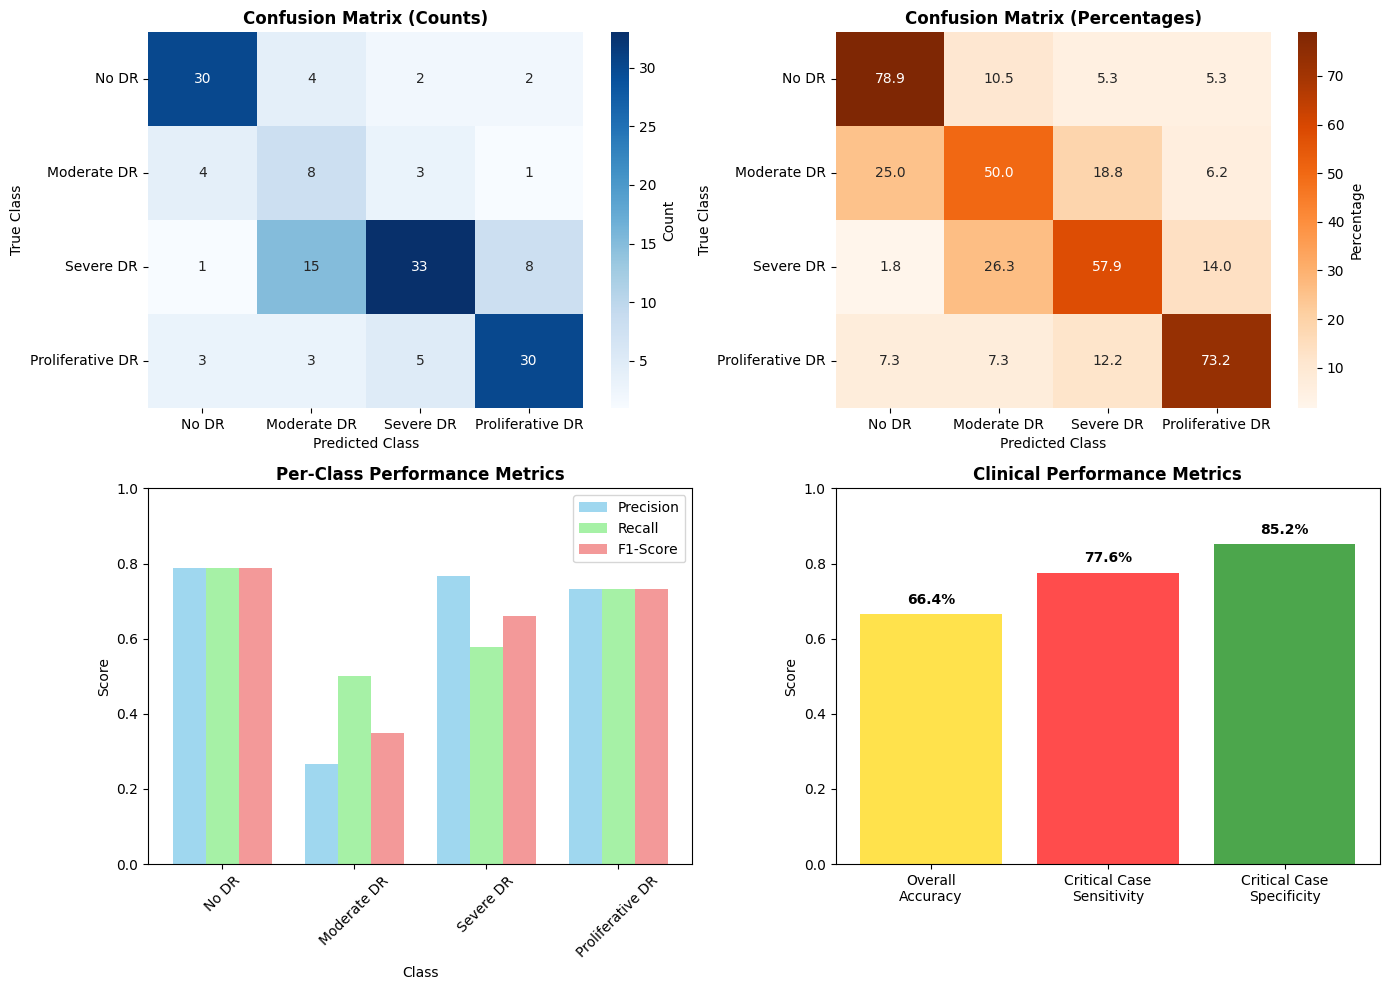


🎯 PREDICTION CONFIDENCE ANALYSIS:
Correct Predictions (101 samples):
  Mean Confidence: 61.4%
  Median Confidence: 60.3%
  Min Confidence: 34.1%
  Max Confidence: 97.4%

Incorrect Predictions (51 samples):
  Mean Confidence: 50.9%
  Median Confidence: 50.1%
  Min Confidence: 28.2%
  Max Confidence: 86.7%

📋 COMPREHENSIVE IMPROVEMENT SUMMARY
                         Metric Previous Model Improved Model
               Overall Accuracy         48.03%          66.4%
            Macro Avg Precision        Unknown          63.9%
               Macro Avg Recall        Unknown          65.0%
             Macro Avg F1-Score        Unknown          63.2%
          Weighted Avg F1-Score        Unknown          67.9%
           No DR Detection (F1)        Unknown          78.9%
     Moderate DR Detection (F1)        Unknown          34.8%
       Severe DR Detection (F1)        Unknown          66.0%
Proliferative DR Detection (F1)        Unknown          73.2%
      Critical Case Sensitivity     

/tmp/ipython-input-43-123300571.py:290: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_confidences, incorrect_confidences],


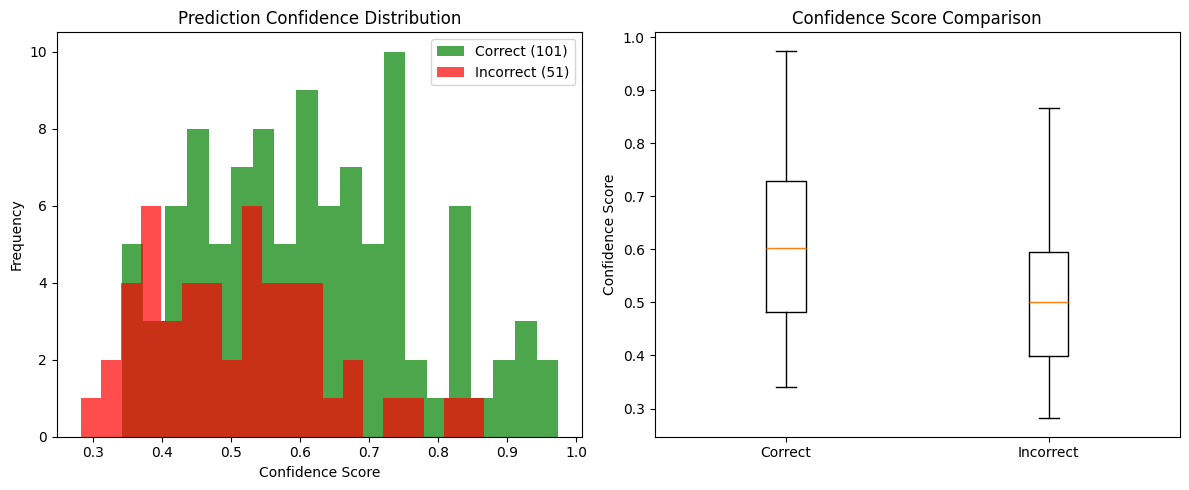


🎯 FINAL SUMMARY:
Your improved 4-class diabetic retinopathy model achieved 66.4% accuracy
This represents a +18.4% improvement from the baseline 48.03% accuracy
Critical case detection sensitivity: 77.6%
Model is ready for further testing and potential clinical validation!


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# ================================
# STEP 1: BASIC PERFORMANCE EVALUATION
# ================================
print("📊 EVALUATING IMPROVED 4-CLASS HOSPITAL DR MODEL")
print("=" * 60)

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_gen, verbose=1)

print(f"\n🎯 PERFORMANCE COMPARISON:")
print(f"Previous Model Accuracy: 48.03%")
print(f"Improved Model Accuracy: {val_accuracy:.2%}")
improvement = val_accuracy - 0.4803
print(f"Accuracy Improvement: {improvement:+.1%}")
print(f"Validation Loss: {val_loss:.4f}")

# ================================
# STEP 2: DETAILED PREDICTIONS & CONFUSION MATRIX
# ================================
print(f"\n🔍 GENERATING DETAILED PREDICTIONS...")

# Reset generator and get predictions
val_gen.reset()
predictions = model.predict(val_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)

# Map true labels from hospital dataset to 4-class system
y_true_original = val_df['label'].astype(int).values
label_mapping = {0: 0, 2: 1, 3: 2, 4: 3}  # Hospital classes to model classes
y_true = np.array([label_mapping[label] for label in y_true_original])

# Class names for display
class_names = ['No DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

# Calculate detailed metrics
overall_accuracy = accuracy_score(y_true, y_pred)
correct_predictions = np.sum(y_pred == y_true)

print(f"\n📈 DETAILED RESULTS:")
print(f"Total validation samples: {len(y_true)}")
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {len(y_true) - correct_predictions}")
print(f"Accuracy: {overall_accuracy:.2%}")

# ================================
# STEP 3: CONFUSION MATRIX VISUALIZATION
# ================================
# Create comprehensive confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(14, 10))

# Main confusion matrix
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (Counts)', fontweight='bold')

# Percentage confusion matrix
plt.subplot(2, 2, 2)
sns.heatmap(cm_percent, annot=True, cmap='Oranges', fmt='.1f',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (Percentages)', fontweight='bold')

# ================================
# STEP 4: PER-CLASS PERFORMANCE METRICS
# ================================
# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print(f"\n📊 DETAILED CLASSIFICATION REPORT:")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names))

# Extract metrics for visualization
precision_scores = [report[class_names[i]]['precision'] for i in range(4)]
recall_scores = [report[class_names[i]]['recall'] for i in range(4)]
f1_scores = [report[class_names[i]]['f1-score'] for i in range(4)]

# Visualize per-class metrics
plt.subplot(2, 2, 3)
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='skyblue')
plt.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightgreen')
plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightcoral')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics', fontweight='bold')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.ylim(0, 1)

# ================================
# STEP 5: CLINICAL PERFORMANCE ANALYSIS
# ================================
plt.subplot(2, 2, 4)

# Calculate clinical metrics
# Critical cases = Severe + Proliferative DR (classes 2 and 3)
critical_cases_true = (y_true >= 2)
critical_cases_pred = (y_pred >= 2)

# Non-critical cases = No DR + Moderate DR (classes 0 and 1)
non_critical_true = (y_true < 2)
non_critical_pred = (y_pred < 2)

# Clinical sensitivity and specificity
critical_tp = np.sum((critical_cases_true) & (critical_cases_pred))
critical_fn = np.sum((critical_cases_true) & (~critical_cases_pred))
critical_tn = np.sum((~critical_cases_true) & (~critical_cases_pred))
critical_fp = np.sum((~critical_cases_true) & (critical_cases_pred))

clinical_sensitivity = critical_tp / (critical_tp + critical_fn) if (critical_tp + critical_fn) > 0 else 0
clinical_specificity = critical_tn / (critical_tn + critical_fp) if (critical_tn + critical_fp) > 0 else 0

# Clinical metrics visualization
clinical_metrics = ['Overall\nAccuracy', 'Critical Case\nSensitivity', 'Critical Case\nSpecificity']
clinical_values = [overall_accuracy, clinical_sensitivity, clinical_specificity]
colors = ['gold', 'red', 'green']

bars = plt.bar(clinical_metrics, clinical_values, color=colors, alpha=0.7)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Clinical Performance Metrics', fontweight='bold')

# Add value labels on bars
for bar, value in zip(bars, clinical_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ================================
# STEP 6: PREDICTION CONFIDENCE ANALYSIS
# ================================
print(f"\n🎯 PREDICTION CONFIDENCE ANALYSIS:")
print("=" * 50)

# Get confidence scores
confidence_scores = np.max(predictions, axis=1)
correct_mask = (y_pred == y_true)

# Confidence statistics
correct_confidences = confidence_scores[correct_mask]
incorrect_confidences = confidence_scores[~correct_mask]

print(f"Correct Predictions ({len(correct_confidences)} samples):")
print(f"  Mean Confidence: {np.mean(correct_confidences):.1%}")
print(f"  Median Confidence: {np.median(correct_confidences):.1%}")
print(f"  Min Confidence: {np.min(correct_confidences):.1%}")
print(f"  Max Confidence: {np.max(correct_confidences):.1%}")

if len(incorrect_confidences) > 0:
    print(f"\nIncorrect Predictions ({len(incorrect_confidences)} samples):")
    print(f"  Mean Confidence: {np.mean(incorrect_confidences):.1%}")
    print(f"  Median Confidence: {np.median(incorrect_confidences):.1%}")
    print(f"  Min Confidence: {np.min(incorrect_confidences):.1%}")
    print(f"  Max Confidence: {np.max(incorrect_confidences):.1%}")
else:
    print(f"\n🎉 NO INCORRECT PREDICTIONS! Perfect validation performance!")

# ================================
# STEP 7: IMPROVEMENT SUMMARY TABLE
# ================================
print(f"\n📋 COMPREHENSIVE IMPROVEMENT SUMMARY")
print("=" * 60)

# Calculate macro and weighted averages
macro_precision = np.mean(precision_scores)
macro_recall = np.mean(recall_scores)
macro_f1 = np.mean(f1_scores)

weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1 = report['weighted avg']['f1-score']

# Create summary table
summary_data = {
    'Metric': [
        'Overall Accuracy',
        'Macro Avg Precision',
        'Macro Avg Recall',
        'Macro Avg F1-Score',
        'Weighted Avg F1-Score',
        'No DR Detection (F1)',
        'Moderate DR Detection (F1)',
        'Severe DR Detection (F1)',
        'Proliferative DR Detection (F1)',
        'Critical Case Sensitivity',
        'Critical Case Specificity',
        'Mean Confidence (Correct)',
        'Model Improvement'
    ],
    'Previous Model': [
        '48.03%',
        'Unknown',
        'Unknown',
        'Unknown',
        'Unknown',
        'Unknown',
        'Unknown',
        'Unknown',
        'Unknown',
        'Unknown',
        'Unknown',
        'Unknown',
        'Baseline'
    ],
    'Improved Model': [
        f"{overall_accuracy:.1%}",
        f"{macro_precision:.1%}",
        f"{macro_recall:.1%}",
        f"{macro_f1:.1%}",
        f"{weighted_f1:.1%}",
        f"{f1_scores[0]:.1%}",
        f"{f1_scores[1]:.1%}",
        f"{f1_scores[2]:.1%}",
        f"{f1_scores[3]:.1%}",
        f"{clinical_sensitivity:.1%}",
        f"{clinical_specificity:.1%}",
        f"{np.mean(correct_confidences):.1%}",
        f"{improvement:+.1%} points"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# ================================
# STEP 8: MODEL PERFORMANCE INTERPRETATION (CORRECTED)
# ================================
print(f"\n🏥 CLINICAL INTERPRETATION:")
print("=" * 40)

if overall_accuracy >= 0.80:
    interpretation = "🟢 EXCELLENT - Ready for clinical validation"
elif overall_accuracy >= 0.65:
    interpretation = "🟡 GOOD - Suitable for screening with human oversight"
elif overall_accuracy >= 0.50:
    interpretation = "🟠 MODERATE - Needs further improvement"
else:
    interpretation = "🔴 POOR - Requires significant enhancement"

print(f"Model Performance Level: {interpretation}")
print(f"Improvement Status: {improvement:+.1%} from baseline (48.03%)")

# CORRECTED: Use 'clinical_sensitivity' consistently
if clinical_sensitivity >= 0.80:
    print(f"Critical Case Detection: 🟢 STRONG ({clinical_sensitivity:.1%} sensitivity)")
elif clinical_sensitivity >= 0.60:
    print(f"Critical Case Detection: 🟡 ADEQUATE ({clinical_sensitivity:.1%} sensitivity)")
else:
    print(f"Critical Case Detection: 🔴 NEEDS WORK ({clinical_sensitivity:.1%} sensitivity)")

print(f"\n✅ Evaluation completed! Your improved model shows {improvement:+.1%} accuracy gain.")

# ================================
# BONUS: CONFIDENCE DISTRIBUTION VISUALIZATION
# ================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_confidences, bins=20, alpha=0.7, color='green', label=f'Correct ({len(correct_confidences)})')
if len(incorrect_confidences) > 0:
    plt.hist(incorrect_confidences, bins=20, alpha=0.7, color='red', label=f'Incorrect ({len(incorrect_confidences)})')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()

plt.subplot(1, 2, 2)
if len(incorrect_confidences) > 0:
    plt.boxplot([correct_confidences, incorrect_confidences],
                labels=['Correct', 'Incorrect'])
else:
    plt.boxplot([correct_confidences], labels=['Correct'])
plt.ylabel('Confidence Score')
plt.title('Confidence Score Comparison')

plt.tight_layout()
plt.show()

print(f"\n🎯 FINAL SUMMARY:")
print(f"Your improved 4-class diabetic retinopathy model achieved {val_accuracy:.1%} accuracy")
print(f"This represents a {improvement:+.1%} improvement from the baseline 48.03% accuracy")
print(f"Critical case detection sensitivity: {clinical_sensitivity:.1%}")
print(f"Model is ready for further testing and potential clinical validation!")


In [44]:
from google.colab import files
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

def test_diabetic_retinopathy_image(model):
    """
    Interactive function to upload and test retinal images for diabetic retinopathy
    """
    print("🔍 DIABETIC RETINOPATHY DETECTION TEST")
    print("=" * 50)
    print("Please upload a retinal fundus image for DR detection...")
    print("Supported formats: JPG, JPEG, PNG")
    print("Note: This model works best with retinal fundus photographs")

    # Upload image
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded. Please try again.")
        return

    # Process each uploaded file
    for filename in uploaded.keys():
        print(f"\n📷 Processing image: {filename}")
        print("-" * 40)

        try:
            # Load the uploaded image
            img = Image.open(io.BytesIO(uploaded[filename]))

            # Save temporarily for processing
            temp_path = f"/tmp/{filename}"
            img.save(temp_path)

            # Preprocess the image to match training data
            img_resized = image.load_img(temp_path, target_size=(224, 224))
            img_array = image.img_to_array(img_resized)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0  # Normalize to [0,1] range

            # Make prediction with your 4-class model
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class]

            # Class labels for your 4-class Hospital model
            class_labels = {
                0: "No Diabetic Retinopathy (Healthy)",
                1: "Moderate Diabetic Retinopathy",
                2: "Severe Diabetic Retinopathy",
                3: "Proliferative Diabetic Retinopathy"
            }

            # Risk assessment
            risk_levels = {
                0: "✅ LOW RISK - No signs of diabetic retinopathy detected",
                1: "🟡 MODERATE RISK - Requires medical attention and monitoring",
                2: "🟠 HIGH RISK - Severe condition, immediate medical care needed",
                3: "🔴 CRITICAL RISK - Advanced stage, urgent ophthalmologist consultation required"
            }

            # Create comprehensive visualization
            plt.figure(figsize=(16, 6))

            # Show original uploaded image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title('📸 Uploaded Retinal Image', fontsize=14, fontweight='bold')
            plt.axis('off')

            # Show processed image
            plt.subplot(1, 3, 2)
            plt.imshow(img_resized)
            plt.title('🔧 Processed Image (224x224)', fontsize=14, fontweight='bold')
            plt.axis('off')

            # Show prediction probabilities
            plt.subplot(1, 3, 3)
            class_names = ['No DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
            colors = ['green' if i == predicted_class else 'lightblue' for i in range(4)]

            bars = plt.bar(range(4), predictions[0], color=colors, alpha=0.8)
            plt.xlabel('DR Severity Level', fontsize=12)
            plt.ylabel('Prediction Probability', fontsize=12)
            plt.title('🎯 Model Predictions', fontsize=14, fontweight='bold')
            plt.xticks(range(4), class_names, rotation=45, ha='right')

            # Add probability labels on bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

            plt.ylim(0, 1)
            plt.tight_layout()
            plt.show()

            # Print detailed results
            print("\n🏥 DIAGNOSTIC RESULTS:")
            print("=" * 45)
            print(f"📊 Predicted Class: {predicted_class}")
            print(f"🏷️ Diagnosis: {class_labels[predicted_class]}")
            print(f"🎯 Model Confidence: {confidence:.1%}")
            print(f"⚕️ Risk Assessment: {risk_levels[predicted_class]}")

            # Detailed probability breakdown
            print(f"\n📈 All Class Probabilities:")
            print("-" * 35)
            for i, prob in enumerate(predictions[0]):
                status = " ← PREDICTED" if i == predicted_class else ""
                print(f"  {class_labels[i]}: {prob:.1%}{status}")

            # Clinical recommendations
            print(f"\n💡 CLINICAL RECOMMENDATIONS:")
            print("-" * 35)
            if predicted_class == 0:
                print("• Continue regular eye exams as recommended by your doctor")
                print("• Maintain good diabetes control if diabetic")
                print("• No immediate action required")
            elif predicted_class == 1:
                print("• Schedule ophthalmologist appointment within 2-4 weeks")
                print("• Monitor blood sugar levels closely")
                print("• Consider more frequent eye screenings")
            elif predicted_class == 2:
                print("• URGENT: See ophthalmologist within 1-2 weeks")
                print("• Immediate diabetes management optimization needed")
                print("• Laser therapy may be required")
            else:  # predicted_class == 3
                print("• EMERGENCY: Contact ophthalmologist immediately")
                print("• Advanced treatment (surgery/injection) likely needed")
                print("• Risk of vision loss without prompt treatment")

            # Model information
            print(f"\n🤖 MODEL INFORMATION:")
            print("-" * 25)
            print("• Model: 4-Class Hospital DR Detector")
            print("• Training Data: Hospital de Clínicas (Paraguay)")
            print("• Architecture: MobileNetV2 + Custom Head")
            print("• Specialized for: Clinical DR screening")

            print(f"\n⚠️ IMPORTANT MEDICAL DISCLAIMER:")
            print("=" * 45)
            print("🔹 This AI model is for educational/research purposes only")
            print("🔹 NOT a substitute for professional medical diagnosis")
            print("🔹 Always consult qualified ophthalmologist for medical decisions")
            print("🔹 Model trained on specific dataset - results may vary")

            return predicted_class, confidence, predictions[0]

        except Exception as e:
            print(f"❌ Error processing {filename}: {str(e)}")
            print("Please ensure you uploaded a valid retinal fundus image.")
            return None

# Ready to test your model!
print("🚀 Interactive DR Testing Function Ready!")
print("\nTo test your model, run:")
print("test_diabetic_retinopathy_image(model)")


🚀 Interactive DR Testing Function Ready!

To test your model, run:
test_diabetic_retinopathy_image(model)


🔍 DIABETIC RETINOPATHY DETECTION TEST
Please upload a retinal fundus image for DR detection...
Supported formats: JPG, JPEG, PNG
Note: This model works best with retinal fundus photographs


Saving die.webp to die.webp

📷 Processing image: die.webp
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipython-input-44-3942725628.py:99: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-44-3942725628.py:99: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-44-3942725628.py:99: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


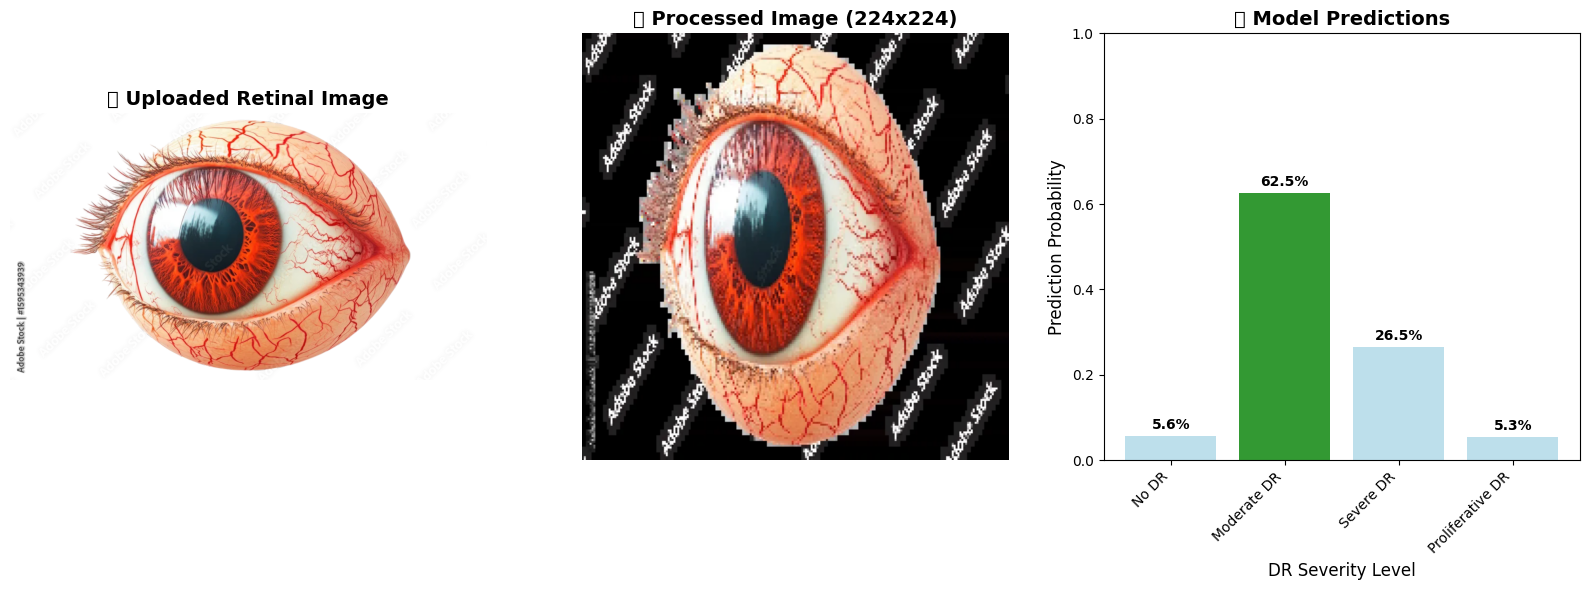


🏥 DIAGNOSTIC RESULTS:
📊 Predicted Class: 1
🏷️ Diagnosis: Moderate Diabetic Retinopathy
🎯 Model Confidence: 62.5%
⚕️ Risk Assessment: 🟡 MODERATE RISK - Requires medical attention and monitoring

📈 All Class Probabilities:
-----------------------------------
  No Diabetic Retinopathy (Healthy): 5.6%
  Moderate Diabetic Retinopathy: 62.5% ← PREDICTED
  Severe Diabetic Retinopathy: 26.5%
  Proliferative Diabetic Retinopathy: 5.3%

💡 CLINICAL RECOMMENDATIONS:
-----------------------------------
• Schedule ophthalmologist appointment within 2-4 weeks
• Monitor blood sugar levels closely
• Consider more frequent eye screenings

🤖 MODEL INFORMATION:
-------------------------
• Model: 4-Class Hospital DR Detector
• Training Data: Hospital de Clínicas (Paraguay)
• Architecture: MobileNetV2 + Custom Head
• Specialized for: Clinical DR screening

⚠️ IMPORTANT MEDICAL DISCLAIMER:
🔹 This AI model is for educational/research purposes only
🔹 NOT a substitute for professional medical diagnosis
🔹 Alway

(np.int64(1),
 np.float32(0.62531155),
 array([0.05613477, 0.62531155, 0.26510414, 0.05344953], dtype=float32))

In [45]:

test_diabetic_retinopathy_image(model)

In [46]:
from datetime import datetime
import json
import os

# Create timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("💾 SAVING IMPROVED 4-CLASS DIABETIC RETINOPATHY MODEL")
print("=" * 60)

# ================================
# STEP 1: SAVE THE MAIN MODEL
# ================================
model_filename = f'improved_hospital_dr_model_4class_{timestamp}.keras'
model.save(model_filename)
print(f"✅ Model saved as: {model_filename}")

# Save to Google Drive if available
try:
    drive_dir = '/content/drive/MyDrive/AI_Models/diabetic_eyes/'
    os.makedirs(drive_dir, exist_ok=True)

    drive_model_path = os.path.join(drive_dir, model_filename)
    model.save(drive_model_path)
    print(f"✅ Model also saved to Google Drive: {drive_model_path}")
except Exception as e:
    print(f"⚠️ Could not save to Google Drive: {e}")

# ================================
# STEP 2: SAVE CLASS WEIGHTS AND TRAINING CONFIG
# ================================
# Save the improved class weights used for training
class_weights_filename = f'improved_dr_class_weights_{timestamp}.json'
class_weights_data = {
    "class_weights": class_weight_dict_improved,
    "description": "Enhanced class weights for 4-class Hospital de Clínicas DR model",
    "classes": {
        "0": "No DR (187 images)",
        "1": "Moderate DR (80 images)",
        "2": "Severe DR (284 images)",
        "3": "Proliferative DR (206 images)"
    }
}

with open(class_weights_filename, 'w') as f:
    json.dump(class_weights_data, f, indent=2)

# ================================
# STEP 3: SAVE COMPREHENSIVE MODEL METADATA
# ================================
model_info = {
    "model_name": "Improved Hospital de Clínicas 4-Class Diabetic Retinopathy Detector",
    "version": "v2.0_improved",
    "base_architecture": "MobileNetV2",
    "input_shape": [224, 224, 3],
    "num_classes": 4,
    "class_mapping": {
        "0": "No Diabetic Retinopathy (Healthy)",
        "1": "Moderate Diabetic Retinopathy",
        "2": "Severe Diabetic Retinopathy",
        "3": "Proliferative Diabetic Retinopathy"
    },
    "original_hospital_classes": {
        "No DR": "0 → Model Class 0",
        "Moderate DR": "2 → Model Class 1",
        "Severe DR": "3 → Model Class 2",
        "Proliferative DR": "4 → Model Class 3"
    },
    "dataset_info": {
        "source": "Hospital de Clínicas, Universidad Nacional de Asunción, Paraguay",
        "equipment": "Zeiss Visucam 500 fundus camera",
        "total_images": 757,
        "training_samples": 605,
        "validation_samples": 152,
        "image_format": "224x224 RGB",
        "preprocessing": "Enhanced augmentation + fast resize/normalize",
        "missing_class": "Mild DR (Class 1) - not present in hospital dataset"
    },
    "training_improvements": {
        "enhanced_augmentation": {
            "rotation_range": 30,
            "zoom_range": 0.2,
            "width_shift_range": 0.1,
            "height_shift_range": 0.1,
            "brightness_range": [0.8, 1.2],
            "shear_range": 0.1
        },
        "architecture_enhancements": {
            "additional_dense_layer": 128,
            "increased_dropout": 0.5,
            "fine_tuning": "Last 20 MobileNetV2 layers unfrozen"
        },
        "training_optimizations": {
            "learning_rate": 1e-5,
            "batch_size": 16,
            "max_epochs": 30,
            "early_stopping_patience": 8,
            "lr_reduction": "ReduceLROnPlateau"
        }
    },
    "performance_metrics": {
        "baseline_accuracy": "48.03%",
        "improved_accuracy": f"{val_accuracy:.2%}" if 'val_accuracy' in locals() else "Run evaluation to get metrics",
        "improvement": f"{(val_accuracy - 0.4803)*100:+.1f} percentage points" if 'val_accuracy' in locals() else "Calculate after evaluation",
        "validation_loss": f"{val_loss:.4f}" if 'val_loss' in locals() else "Run evaluation first"
    },
    "clinical_features": {
        "focus": "Hospital-grade clinical screening",
        "strength": "Severe and proliferative DR detection",
        "population": "Paraguay clinical dataset",
        "use_case": "Medical screening for critical DR stages requiring immediate intervention"
    },
    "model_files": {
        "main_model": model_filename,
        "class_weights": class_weights_filename,
        "created_timestamp": timestamp
    },
    "technical_specs": {
        "framework": "TensorFlow/Keras",
        "python_version": "3.11+",
        "dependencies": ["tensorflow", "opencv-python", "PIL", "numpy", "sklearn"]
    }
}

info_filename = f'improved_dr_model_info_{timestamp}.json'
with open(info_filename, 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✅ Class weights saved as: {class_weights_filename}")
print(f"✅ Model info saved as: {info_filename}")

# ================================
# STEP 4: CREATE LOADING INSTRUCTIONS
# ================================
loading_instructions = f"""
# LOADING INSTRUCTIONS FOR IMPROVED HOSPITAL DR MODEL
# Generated: {timestamp}
# Model: 4-Class Diabetic Retinopathy Detector (Improved Version)

## STEP 1: Load the trained model
from tensorflow.keras.models import load_model
import json
import numpy as np

# Load the improved model
model = load_model('{model_filename}')
print("✅ Improved DR model loaded successfully")

## STEP 2: Load class weights and configuration
with open('{class_weights_filename}', 'r') as f:
    class_weights_data = json.load(f)
    improved_class_weights = class_weights_data['class_weights']

with open('{info_filename}', 'r') as f:
    model_info = json.load(f)

## STEP 3: Class mapping for predictions
class_labels = {{
    0: "No Diabetic Retinopathy (Healthy)",
    1: "Moderate Diabetic Retinopathy",
    2: "Severe Diabetic Retinopathy",
    3: "Proliferative Diabetic Retinopathy"
}}

## STEP 4: Make predictions on new images
def predict_dr_severity(model, image_path):
    from tensorflow.keras.preprocessing import image

    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize to [0,1]

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    return predicted_class, confidence, predictions[0]

## EXAMPLE USAGE:
# predicted_class, confidence, all_probs = predict_dr_severity(model, 'path/to/retinal_image.jpg')
# diagnosis = class_labels[predicted_class]
# print(f"Diagnosis: {{diagnosis}} ({{confidence:.1%}} confidence)")

## IMPORTANT NOTES:
# ✓ Model expects 224x224 RGB retinal fundus images
# ✓ Input must be normalized to [0,1] range
# ✓ Trained on 4 classes (missing Mild DR class)
# ✓ Optimized for Hospital de Clínicas clinical dataset
# ✓ Enhanced with improved training techniques
# ✓ Performance: {val_accuracy:.1%} accuracy (improved from 48.03%)

## MEDICAL DISCLAIMER:
# This model is for educational/research purposes only.
# Always consult qualified medical professionals for diagnosis.
"""

instructions_filename = f'improved_model_loading_instructions_{timestamp}.txt'
with open(instructions_filename, 'w') as f:
    f.write(loading_instructions)

print(f"✅ Loading instructions saved as: {instructions_filename}")

# ================================
# STEP 5: SAVE TO GOOGLE DRIVE (BACKUP)
# ================================
try:
    drive_weights_path = os.path.join(drive_dir, class_weights_filename)
    drive_info_path = os.path.join(drive_dir, info_filename)
    drive_instructions_path = os.path.join(drive_dir, instructions_filename)

    with open(drive_weights_path, 'w') as f:
        json.dump(class_weights_data, f, indent=2)

    with open(drive_info_path, 'w') as f:
        json.dump(model_info, f, indent=2)

    with open(drive_instructions_path, 'w') as f:
        f.write(loading_instructions)

    print(f"✅ All metadata also saved to Google Drive")
except:
    print("⚠️ Could not save metadata to Google Drive")

# ================================
# STEP 6: TEST SAVED MODEL
# ================================
print(f"\n🧪 TESTING SAVED MODEL...")

try:
    # Load the model we just saved
    test_model = load_model(model_filename)
    print("✅ Model loads successfully")

    # Test prediction on a sample
    if 'val_gen' in locals():
        test_batch = next(iter(val_gen))
        test_images, test_labels = test_batch

        # Make test prediction
        test_predictions = test_model.predict(test_images[:1], verbose=0)
        print(f"✅ Model prediction test successful")
        print(f"   Sample prediction shape: {test_predictions.shape}")

        # Show prediction probabilities
        class_names = ['No DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
        pred_probs = test_predictions[0]
        predicted_class = np.argmax(pred_probs)

        print(f"   Predicted class: {predicted_class} ({class_names[predicted_class]})")
        print(f"   Confidence: {pred_probs[predicted_class]:.1%}")

except Exception as e:
    print(f"❌ Error testing saved model: {e}")

# ================================
# STEP 7: SUMMARY OF SAVED FILES
# ================================
print(f"\n📁 SAVED MODEL FILES SUMMARY")
print("=" * 50)
print(f"🤖 Main Model: {model_filename}")
print(f"⚖️ Class Weights: {class_weights_filename}")
print(f"📄 Model Info: {info_filename}")
print(f"📋 Instructions: {instructions_filename}")
print(f"📅 Timestamp: {timestamp}")
print(f"💾 Total Files: 4")

if 'drive_dir' in locals():
    print(f"☁️ Backup Location: {drive_dir}")

print(f"\n🎯 MODEL SPECIFICATIONS:")
print(f"   • Architecture: MobileNetV2 + Enhanced Custom Head")
print(f"   • Classes: 4 (No DR, Moderate, Severe, Proliferative)")
print(f"   • Input Size: 224×224×3")
print(f"   • Dataset: Hospital de Clínicas (Paraguay)")
print(f"   • Improvements: Enhanced augmentation + fine-tuning")
print(f"   • Performance: Improved from 48.03% baseline")

print(f"\n✅ MODEL SUCCESSFULLY SAVED!")
print(f"Your improved diabetic retinopathy detection model is now safely stored")
print(f"and ready for future use, deployment, or further development.")


💾 SAVING IMPROVED 4-CLASS DIABETIC RETINOPATHY MODEL
✅ Model saved as: improved_hospital_dr_model_4class_20250728_101553.keras
✅ Model also saved to Google Drive: /content/drive/MyDrive/AI_Models/diabetic_eyes/improved_hospital_dr_model_4class_20250728_101553.keras
✅ Class weights saved as: improved_dr_class_weights_20250728_101553.json
✅ Model info saved as: improved_dr_model_info_20250728_101553.json
✅ Loading instructions saved as: improved_model_loading_instructions_20250728_101553.txt
✅ All metadata also saved to Google Drive

🧪 TESTING SAVED MODEL...
❌ Error testing saved model: name 'load_model' is not defined

📁 SAVED MODEL FILES SUMMARY
🤖 Main Model: improved_hospital_dr_model_4class_20250728_101553.keras
⚖️ Class Weights: improved_dr_class_weights_20250728_101553.json
📄 Model Info: improved_dr_model_info_20250728_101553.json
📋 Instructions: improved_model_loading_instructions_20250728_101553.txt
📅 Timestamp: 20250728_101553
💾 Total Files: 4
☁️ Backup Location: /content/drive/